In [52]:
import pandas as pd
import numpy as np
import pickle
from geopy.geocoders import Nominatim
import os
import rasterio
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [30]:
# Path to the shapefile
shp_path = r'C:\\Users\liamr\Documents\Playground\river_plastic\data\Meijer2021_midpoint_emissions.shp'

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shp_path)

# Loading the .dbf file separately
dbf_path = r'C:\\Users\liamr\Documents\Playground\river_plastic\data\Meijer2021_midpoint_emissions.dbf'

dbf_data = DBF(dbf_path)


In [31]:
# Convert to pandas DataFrame
df = pd.DataFrame(iter(dbf_data))

# Inspect the columns in the .dbf file
print(df.columns)

# Check the first few rows of the data
# print(df.head())

Index(['dots_exten'], dtype='object')


In [32]:
# Display the first few rows to understand the structure of the data
print(gdf.head())

   dots_exten                     geometry
0    0.164904  POINT (168.79792 -46.58083)
1    0.124932  POINT (168.34875 -46.44708)
2    1.213370  POINT (168.33708 -46.41875)
3    0.121138  POINT (168.02125 -46.35792)
4    0.197533  POINT (169.81125 -46.34375)


In [33]:
print(gdf[['dots_exten', 'geometry']].head(20))  # Check the first 20 rows


    dots_exten                     geometry
0     0.164904  POINT (168.79792 -46.58083)
1     0.124932  POINT (168.34875 -46.44708)
2     1.213370  POINT (168.33708 -46.41875)
3     0.121138  POINT (168.02125 -46.35792)
4     0.197533  POINT (169.81125 -46.34375)
5     0.179718  POINT (170.19708 -46.05292)
6     0.382871  POINT (170.39208 -45.92875)
7     0.144652  POINT (170.50958 -45.88875)
8     0.593496  POINT (170.51708 -45.87542)
9     0.236202  POINT (171.25958 -44.42167)
10    0.102279  POINT (171.25708 -44.36125)
11    0.129572  POINT (171.35042 -44.28125)
12    0.376397  POINT (172.37875 -43.85625)
13    2.268480  POINT (172.75042 -43.55125)
14    2.850020  POINT (172.72458 -43.48792)
15    0.503895  POINT (172.70708 -43.39125)
16    0.207065  POINT (147.33792 -42.88375)
17    0.108960  POINT (147.45792 -42.77792)
18    0.499766  POINT (171.19208 -42.43875)
19    0.362587  POINT (174.06208 -41.50125)


In [34]:
# Sort by emission values and filter top 1000
top_1000_rivers = gdf.sort_values(by='dots_exten', ascending=False).head(1000)


In [35]:
top_1000_rivers.head()

,dots_exten,geometry
12639,62591.9,POINT (120.95708 14.59542)
12656,13450.2,POINT (120.94833 14.64958)
16880,13432.9,POINT (72.91292 19.28958)
13361,12816.0,POINT (101.38875 3.00292)
12693,12398.3,POINT (120.90042 14.71708)


In [36]:
# Define bounding box for Southeast Asia (latitude and longitude ranges)
southeast_asia_rivers = top_1000_rivers[
    (top_1000_rivers.geometry.y > 0) & (top_1000_rivers.geometry.y < 20) &
    (top_1000_rivers.geometry.x > 90) & (top_1000_rivers.geometry.x < 120)
]


In [37]:
southeast_asia_rivers.count()

dots_exten    176
geometry      176
dtype: int64

In [38]:
# Focusing on only SE Asia rivers - creating df
df = pd.DataFrame(southeast_asia_rivers)

# Create a geometry column
# df['geometry'] = df.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

df['lon'] = df.geometry.apply(lambda p: round(p.x,5))
df['lat'] = df.geometry.apply(lambda p: round(p.y,5))

# # Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [39]:
# Optionally, check CRS and set it if needed
# df.crs = "EPSG:4326" 

In [40]:
df = df.rename(columns={'dots_exten': 'pollution_volume'})
df

,pollution_volume,geometry,lon,lat
13361,12816.000,POINT (101.38875 3.00292),101.38875,3.00292
14525,4127.440,POINT (106.74708 10.49875),106.74708,10.49875
15365,4027.330,POINT (100.55795 13.61573),100.55795,13.61573
16338,3615.390,POINT (96.19083 16.77458),96.19083,16.77458
7006,3274.700,POINT (110.39875 1.55542),110.39875,1.55542
...,...,...,...,...
14778,177.417,POINT (109.00929 11.54262),109.00929,11.54262
13473,176.705,POINT (100.61625 4.44625),100.61625,4.44625
15815,175.480,POINT (95.71042 16.07542),95.71042,16.07542
16334,174.970,POINT (96.12542 16.76208),96.12542,16.76208


### Visualising the map

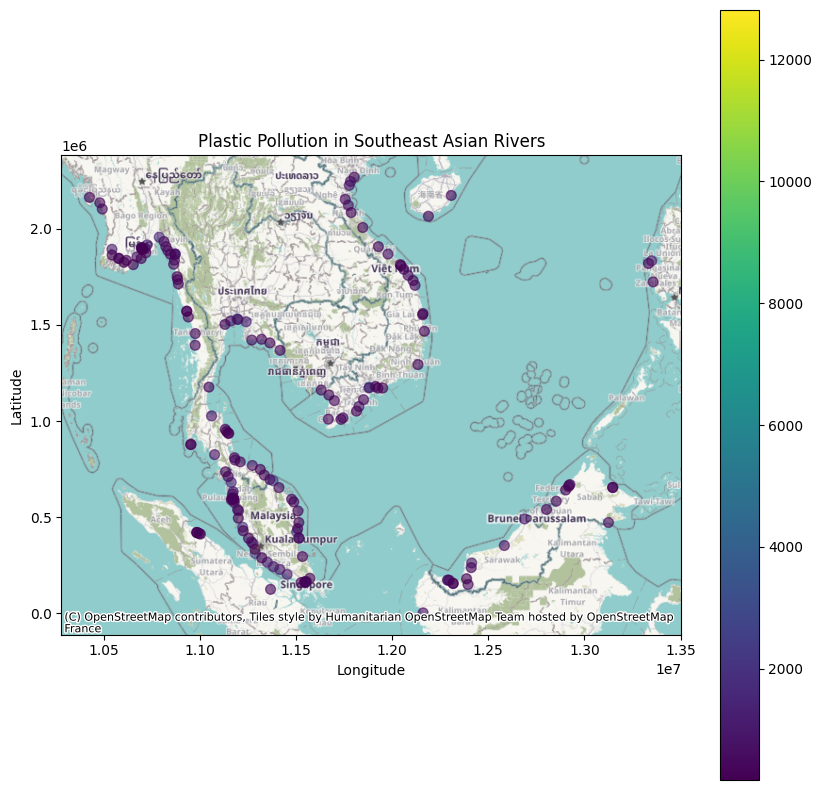

In [41]:
import matplotlib.pyplot as plt
import contextily as ctx

# Project to Web Mercator for better mapping with contextily
gdf = gdf.to_crs(epsg=3857)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rivers
gdf.plot(column='dots_exten', ax=ax, legend=True,
         cmap='viridis', markersize=50, alpha=0.6)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs)

# Set title and labels
ax.set_title('Plastic Pollution in Southeast Asian Rivers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


- These are all the South-East rivers from the top 1000  -> 176 in total
- This project will aim to add a seasonal component to these rivers, with the focus on seasonal impacts on P(M) for simplicity

### Integrating Climate Data

- Obtaining precipitation data and wind data from WorldClim2
- Optional Enhancement: Land Use and Terrain Data -> from HYDROATLAS or GLAD Land Use
- Optional Enhancement: Waste Management Data -> The World Bank’s What a Waste database

Integration Plan:

- Integrate these as monthly variables tied to each river
- Historical climate averages then to be used to model how changes in precipitation and wind seasonally impact plastic mobilization P(M)

In [42]:
df

,pollution_volume,geometry,lon,lat
13361,12816.000,POINT (101.38875 3.00292),101.38875,3.00292
14525,4127.440,POINT (106.74708 10.49875),106.74708,10.49875
15365,4027.330,POINT (100.55795 13.61573),100.55795,13.61573
16338,3615.390,POINT (96.19083 16.77458),96.19083,16.77458
7006,3274.700,POINT (110.39875 1.55542),110.39875,1.55542
...,...,...,...,...
14778,177.417,POINT (109.00929 11.54262),109.00929,11.54262
13473,176.705,POINT (100.61625 4.44625),100.61625,4.44625
15815,175.480,POINT (95.71042 16.07542),95.71042,16.07542
16334,174.970,POINT (96.12542 16.76208),96.12542,16.76208


In [43]:
# Rank the rivers by plastic volume in descending order (higher plastic volume = higher rank)
df['rank'] = df['pollution_volume'].rank(ascending=False, method='dense').astype(int)

# Sort the DataFrame by rank if you want to see the order
df = df.sort_values(by='rank')

# top 10 polluting rivers in SE Asia
SE_top_10 = df.head(10)
SE_top_10_pts = SE_top_10[['lon', 'lat', 'pollution_volume']]	

In [44]:
# retrieving the country that each river belongs to and adding to the df
geolocator = Nominatim(user_agent="river_locator")


def get_country(lat, lon):
    location = geolocator.reverse((lat, lon), language='en')
    
    return location.raw.get('address', {}).get('country', None)


# Apply to DataFrame
SE_top_10_pts.loc[:, 'country'] = SE_top_10_pts.apply(lambda row: get_country(row['lat'], row['lon']), axis=1)

SE_top_10_pts


C:\Users\liamr\AppData\Local\Temp\ipykernel_14044\1979148217.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SE_top_10_pts.loc[:, 'country'] = SE_top_10_pts.apply(lambda row: get_country(row['lat'], row['lon']), axis=1)


,lon,lat,pollution_volume,country
13361,101.38875,3.00292,12816.00,Malaysia
14525,106.74708,10.49875,4127.44,Vietnam
15365,100.55795,13.61573,4027.33,Thailand
16338,96.19083,16.77458,3615.39,Myanmar
7006,110.39875,1.55542,3274.70,Malaysia
13349,101.41125,2.80458,2829.21,Malaysia
16367,96.10625,16.84125,2488.62,Myanmar
13615,102.24458,6.18208,2466.92,Malaysia
13414,103.34292,3.80625,2186.88,Malaysia
13241,103.79750,1.49625,2143.48,Malaysia


##### Next, want to add the historical weather data, from Climdata

In [45]:
# # Rasterio is used to process the .tif file

# # Directory where wind speed data files are all found
# tif_wind_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_wind'

# # Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
# tif_wind_files = sorted([os.path.join(tif_wind_directory, f) for f in os.listdir(tif_wind_directory) if f.endswith('.tif')])


# # Directory where precipitation data files are all found
# tif_rain_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_prec'

# # Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
# tif_rain_files = sorted([os.path.join(tif_rain_directory, f) for f in os.listdir(tif_rain_directory) if f.endswith('.tif')])


for every location, I need to extract the average wind speed and the average precipitation

In [ ]:
# selecting the coordinates from the top polluting rivers
pts = SE_top_10_pts.copy()
# arranging the index so it starts at 1
pts.index = np.arange(1, len(pts) + 1)
# coordinates to be used for extracting from the raster
coords = [(x,y) for x, y in zip(pts['lon'], pts['lat'])]

pts

,lon,lat,country
1,101.38875,3.00292,Malaysia
2,106.74708,10.49875,Vietnam
3,100.55795,13.61573,Thailand
4,96.19083,16.77458,Myanmar
5,110.39875,1.55542,Malaysia
6,101.41125,2.80458,Malaysia
7,96.10625,16.84125,Myanmar
8,102.24458,6.18208,Malaysia
9,103.34292,3.80625,Malaysia
10,103.79750,1.49625,Malaysia


##### PROBLEM:
- This is long-term climate data, not more recent and varying weather patters month on month
- This is available for precipitation on WorldClim, but not for wind speed
- Will simplify the model for now, using only precipitation and potentially wind speed later on
- I will keep the above code for reference as it will be useful, but this cell will include code for more recent precipitation data

In [ ]:
# Rasterio is used to process the .tif file
# Processing the .tif files decade by decade

# Directory where wind speed data files are all found
tif_wind_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_wind'

# Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
tif_wind_files = sorted([os.path.join(tif_wind_directory, f) for f in os.listdir(tif_wind_directory) if f.endswith('.tif')])


# Directory where precipitation data files are all found
tif_rain_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_prec'

# Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
tif_rain_files = sorted([os.path.join(tif_rain_directory, f) for f in os.listdir(tif_rain_directory) if f.endswith('.tif')])

In [47]:
# Rasterio is used to process the .tif file
# Processing the precipitation .tif files decade by decade

# Folder where each decade of precipitation data is stored
base_dir = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\rain_decades'

# selecting the coordinates from the top polluting rivers
pts = SE_top_10_pts.copy()
# arranging the index so it starts at 1
pts.index = np.arange(1, len(pts) + 1)
# coordinates to be used for extracting from the raster
coords = [(x,y) for x, y in zip(pts['lon'], pts['lat'])]

# Initialize list to store all the data to be parsed
time_series_data = []

# Initializing month and year variables, starting from the first month of data
month = 1
year = 1960

# Iterate through each folder in the base directory, in chronological order
for decade_folder in sorted(os.listdir(base_dir)):
    decade_folder_path = os.path.join(base_dir, decade_folder)

    # using if statement to ensure logic is only carried out on a decade folder
    if os.path.isdir(decade_folder_path):
        # Now iterating through each file in the current decade folder
        for rain_file in sorted(os.listdir(decade_folder_path)):
                 # To avoid the readme.txt file in the folders
                 if rain_file.endswith('.tif'):
                    # state the file path as an input for rasterio
                    rain_file_path = os.path.join(decade_folder_path, rain_file)
                    with rasterio.open(rain_file_path) as src_rain:
                    # Extract the precipitation values for every rivers, given the coordinates
                        sampled_values_rain = [val[0] for val in src_rain.sample(coords)]
                        


                # Create a DataFrame for the current month
                    month_data = pd.DataFrame({
                        'river_ID': pts.index, # Adding unique IDs or indices for rivers. For top 10 SE rivers, this is in order of yearly plastic pollution
                        'country': pts['country'],
                        'lon': pts['lon'],
                        'lat': pts['lat'],
                        'year': year,  
                        'month': month,
                        'avg_precipitation': sampled_values_rain
                    })

                    # Finally, appending each month to the time_series_data list
                    time_series_data.append(month_data)

                    # logic for assigning the correct month
                    if month < 12:
                        month += 1
                    elif month == 12:
                        month = 1 
                        year += 1
                    


In [ ]:
time_series_data

[    river_ID   country        lon       lat  year  month  avg_precipitation
 1          1  Malaysia  101.38875   3.00292  1960      1         263.625000
 2          2   Vietnam  106.74708  10.49875  1960      1           4.725000
 3          3  Thailand  100.55795  13.61573  1960      1           4.750000
 4          4   Myanmar   96.19083  16.77458  1960      1           7.125000
 5          5  Malaysia  110.39875   1.55542  1960      1         717.250000
 6          6  Malaysia  101.41125   2.80458  1960      1         254.233337
 7          7   Myanmar   96.10625  16.84125  1960      1           7.175000
 8          8  Malaysia  102.24458   6.18208  1960      1         274.325012
 9          9  Malaysia  103.34292   3.80625  1960      1         514.099976
 10        10  Malaysia  103.79750   1.49625  1960      1         168.600006,
     river_ID   country        lon       lat  year  month  avg_precipitation
 1          1  Malaysia  101.38875   3.00292  1960      2         125.65000

In [48]:
ts_df = pd.concat(time_series_data, ignore_index=True)
ts_df

,river_ID,country,lon,lat,year,month,avg_precipitation
0,1,Malaysia,101.38875,3.00292,1960,1,263.625
1,2,Vietnam,106.74708,10.49875,1960,1,4.725
2,3,Thailand,100.55795,13.61573,1960,1,4.750
3,4,Myanmar,96.19083,16.77458,1960,1,7.125
4,5,Malaysia,110.39875,1.55542,1960,1,717.250
...,...,...,...,...,...,...,...
7195,6,Malaysia,101.41125,2.80458,2019,12,30.000
7196,7,Myanmar,96.10625,16.84125,2019,12,32.000
7197,8,Malaysia,102.24458,6.18208,2019,12,29.500
7198,9,Malaysia,103.34292,3.80625,2019,12,30.000


In [49]:
print(isinstance(ts_df, pd.DataFrame))

True


In [50]:
SE_top_10_pts

,lon,lat,pollution_volume,country
13361,101.38875,3.00292,12816.00,Malaysia
14525,106.74708,10.49875,4127.44,Vietnam
15365,100.55795,13.61573,4027.33,Thailand
16338,96.19083,16.77458,3615.39,Myanmar
7006,110.39875,1.55542,3274.70,Malaysia
13349,101.41125,2.80458,2829.21,Malaysia
16367,96.10625,16.84125,2488.62,Myanmar
13615,102.24458,6.18208,2466.92,Malaysia
13414,103.34292,3.80625,2186.88,Malaysia
13241,103.79750,1.49625,2143.48,Malaysia


In [53]:
SE_top_10_pts.to_pickle('C:\\Users\\liamr\\Documents\\Playground\\backup\\river_plastic_pollution\\data\\SE_top_10_pts.pkl')
ts_df.to_pickle('C:\\Users\\liamr\\Documents\\Playground\\backup\\river_plastic_pollution\\data\\ts_df.pkl')